<a href="https://colab.research.google.com/github/zzunairaa/my_nlp_notes/blob/main/Word2Vec_CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A language model learns the statistical structure of language: **given some words, what is the probability of the next word?**


| Type              | Example                               | Idea                                      |
| ----------------- | ------------------------------------- | ----------------------------------------- |
| (1) Algebraic     | **LSA (Latent Semantic Analysis)**    | Decompose co-occurrence matrices          |
| (2) Probabilistic | **LDA (Latent Dirichlet Allocation)** | Model documents as probabilistic mixtures, Great for topic modeling|
| (3) Neural        | **Word2Vec, GloVe, ELMo, BERT**       | Learn distributed vector representations  |


**Neural type>**

The neural type learns continuous valued embeddings that preserve semantic similarity.

Instead of counting or probabilities, they train small neural nets to learn dense vector embeddings for words or sentences.

Each word → represented as a point in high-dimensional space.

Similar meaning → closer vectors.

| Subtype                          | Example         | Core Idea                           |
| -------------------------------- | --------------- | ----------------------------------- |
|  **Monosemic**              | Word2Vec, GloVe | One fixed vector per word           |
|  **Polysemic / Contextual** | ELMo, BERT      | Dynamic vector per sentence context |


**Word2Vec (CBOW Model)**
Predict a target word from the context words surrounding it.

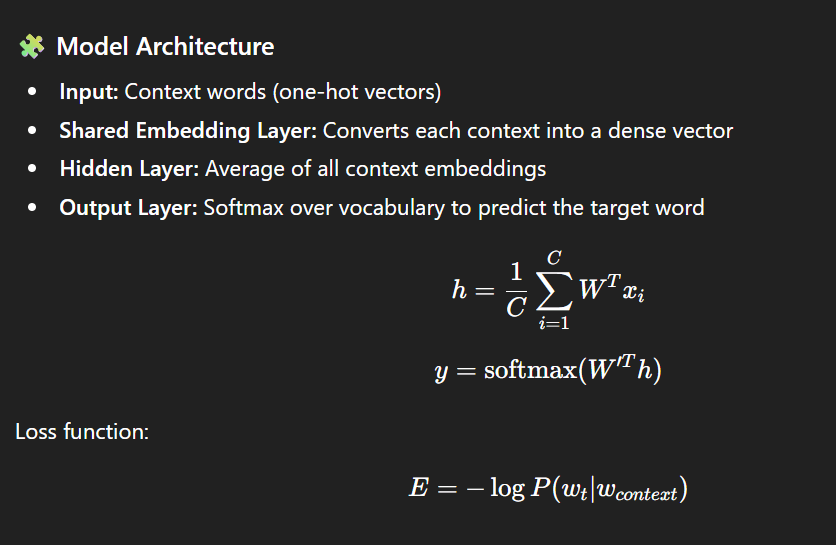

xi -> one hot vector

W -> weight matrix

C -> context words

context vector (h)

**What Is embedding_dim?**

It’s the number of dimensions (or features) in each word vector.
You can think of it like the number of coordinates needed to describe a word’s meaning.

If embedding_dim = 3,
then:

| Word    | 3-D Vector      |
| ------- | --------------- |
| “king”  | [0.8, 0.1, 0.2] |
| “queen” | [0.9, 0.2, 0.3] |
| “apple” | [0.1, 0.8, 0.5] |

The numbers are learned so that:

similar words (king, queen) have similar vectors.

unrelated words (king, apple) are far apart.

# **Build a Mini Word2Vec CBOW in Python**


In [1]:
#Import & Prepare Data
import torch
import torch.nn as nn
import torch.optim as optim

# Sample tiny corpus
sentences = [
    "king queen man woman",
    "apple banana fruit",
    "paris france capital city"
]


In [2]:
# Split all sentences into words
words = set(" ".join(sentences).split())

# Create word-index mappings
vocab = {w: i for i, w in enumerate(words)}
inv_vocab = {i: w for w, i in vocab.items()}

V = len(vocab)
print("Vocabulary:", vocab)


Vocabulary: {'city': 0, 'fruit': 1, 'king': 2, 'man': 3, 'paris': 4, 'apple': 5, 'woman': 6, 'queen': 7, 'france': 8, 'capital': 9, 'banana': 10}


In [4]:
window = 2  # Look 2 words before and 2 words after the target word as context
pairs = []

for sent in sentences:
    tokens = sent.split()
    for i, word in enumerate(tokens):
        for j in range(-window, window+1): #This goes over positions around the target word (left and right):
            if j == 0 or i+j < 0 or i+j >= len(tokens):
                continue
            context = tokens[i+j]
            pairs.append((context, word)) #This creates a training pair

print("Sample (context → target) pairs:", pairs[:10])


Sample (context → target) pairs: [('queen', 'king'), ('man', 'king'), ('king', 'queen'), ('man', 'queen'), ('woman', 'queen'), ('king', 'man'), ('queen', 'man'), ('woman', 'man'), ('queen', 'woman'), ('man', 'woman')]


idk but i thought the intuition is similar to  trigram models but CBOW Predict target word from surrounding context words
and ngram like trigram Model sequence probabilities of n previous consecutive words.

In [5]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)  # Embedding matrix W
        self.linear = nn.Linear(embed_dim, vocab_size)         # Output layer W'

    def forward(self, context_ids):
        embeds = self.embeddings(context_ids)  # Lookup embeddings for context words
        hidden = embeds.mean(dim=0).view(1, -1) # Average them to get the context vector
        out = self.linear(hidden)                # Predict scores for all words in vocab
        return out


| Layer           | What It Does                                               |
| --------------- | ---------------------------------------------------------- |
| `nn.Embedding`  | Learns dense vector representations (word → vector)        |
| `embeds.mean()` | CBOW averages context embeddings                           |
| `nn.Linear`     | Projects embedding back to vocab size                      |
| Output          | A score for each word → which word likely fits the context |


In [6]:
model = CBOW(vocab_size=V, embed_dim=8)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)


In [7]:
for epoch in range(200):
    total_loss = 0
    for context, target in pairs:
        context_var = torch.tensor([vocab[context]], dtype=torch.long) #64-bit integers, indices (like word IDs)
        target_var = torch.tensor([vocab[target]], dtype=torch.long)

        optimizer.zero_grad()             # Reset previous gradients
        out = model(context_var)          # Forward pass (embedding lookup, linear layer, softmax)
        loss = loss_fn(out, target_var)   # Compute loss
        loss.backward()                   # Backpropagate PyTorch automatically applies backpropagation to compute all gradients.
        optimizer.step()                  # Update weights

        total_loss += loss.item()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 0, Loss: 70.8079
Epoch 50, Loss: 29.0894
Epoch 100, Loss: 28.5198
Epoch 150, Loss: 28.2040


| Step                    | What It Does                        | Why Important             |
| ----------------------- | ----------------------------------- | ------------------------- |
| `optimizer.zero_grad()` | Clears old gradients                | Prevents accumulation     |
| `loss.backward()`       | Computes gradients for current loss | Required for backprop     |
| `optimizer.step()`      | Updates weights using new gradients | Performs gradient descent |


In [8]:
for word, idx in vocab.items():
    print(word, "→", model.embeddings.weight[idx].detach().numpy())


city → [-0.17264919  0.08298364  0.6811445  -0.10644059  1.0200535  -1.4873825
 -0.10261287  1.9438579 ]
fruit → [ 0.0528676   0.31752703 -1.3366468  -0.35816234  1.0753312  -0.44383454
  2.2223747  -1.41043   ]
king → [-0.25935945 -0.5670737   0.01796764  1.0784696  -1.059636    0.79196113
  0.20422593 -0.37595344]
man → [ 0.6923671   0.1160485  -0.57931906  0.33401552  0.7965794   2.433696
 -0.07003931  0.58613455]
paris → [ 0.22361782  0.08484511 -0.08642538 -1.298454   -1.3800164  -0.84772587
  1.4182402   0.78204364]
apple → [-0.11418152  0.10730379  1.3953084   1.158954    1.9577734  -0.20593637
  0.11590574 -1.2591149 ]
woman → [-0.93824977  0.23537938 -0.25601202  1.011673   -1.759261    1.0760596
  0.5420225  -1.228748  ]
queen → [-1.0539657  -0.85870415 -1.4702184   0.16524483  0.19728455  0.6500511
 -0.7447574   1.0790436 ]
france → [ 0.6420389  -0.824022    0.6043125   0.5628792  -0.8403993  -0.8355802
 -1.4323249   0.02970302]
capital → [ 1.2795635  -0.42825487  0.28339747

The cosine similarity measures how similar two vectors are in direction, ignoring their magnitude (length).

Why Use Cosine Similarity (and Not Euclidean Distance)?

Because word embeddings are direction based,
we care about orientation in space, not the absolute distance.

Cosine similarity = compares angle between vectors

Euclidean distance = compares magnitude (length) + direction

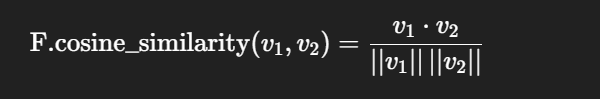

In [12]:
import torch.nn.functional as F

def cosine_similarity(word1, word2):
    v1 = model.embeddings.weight[vocab[word1]]
    v2 = model.embeddings.weight[vocab[word2]]
    sim = F.cosine_similarity(v1, v2, dim=0)
    return sim.item()

print("Similarity(king, queen):", cosine_similarity("king", "queen"))
print("Similarity(apple, banana):", cosine_similarity("apple", "banana"))


Similarity(king, queen): 0.14179956912994385
Similarity(apple, banana): 0.2769530415534973


Embedding matrix shape: (11, 8)


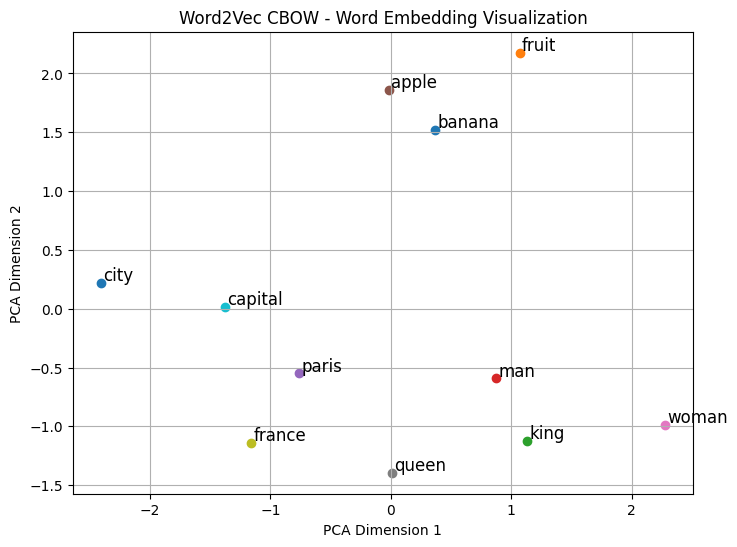

In [13]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


embeddings = model.embeddings.weight.detach().numpy()
print("Embedding matrix shape:", embeddings.shape)

# Reduce embedding dimensions to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
for i, word in enumerate(vocab.keys()):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x+0.02, y+0.02, word, fontsize=12)

plt.title("Word2Vec CBOW - Word Embedding Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()


# **PROBLEM WITH CBOW?**

*Each word gets one fixed vector in the embedding matrix. No matter where or how you use it, its vector is always the same.*


In [28]:
from gensim.models import Word2Vec #gensim is a library built specifically for training and using real Word2Vec models efficiently.
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [29]:
# Sample mixed-context corpus
# A tiny balanced dataset with both meanings of "bank"
sentences = [
    # --- RIVER BANK CONTEXT ---
    ["the", "river", "bank", "was", "covered", "with", "grass"],
    ["the", "boat", "reached", "the", "bank", "of", "the", "river"],
    ["the", "children", "played", "near", "the", "bank", "and", "caught", "fish"],
    ["the", "bank", "was", "slippery", "after", "the", "rain"],
    ["the", "fisherman", "rested", "on", "the", "bank", "watching", "the", "water"],

    # --- FINANCIAL BANK CONTEXT ---
    ["the", "bank", "approved", "the", "loan"],
    ["she", "deposited", "money", "in", "the", "bank"],
    ["the", "customer", "withdrew", "cash", "from", "the", "bank"],
    ["the", "bank", "manager", "approved", "the", "transaction"],
    ["he", "opened", "a", "new", "account", "at", "the", "bank"]
]

# Train Word2Vec (CBOW)
model = Word2Vec(sentences, vector_size=50, window=3, min_count=1, sg=0)


In [31]:
# Get vectors
v_bank = model.wv['bank']
v_river = model.wv['river']
v_money = model.wv['money']

# Cosine similarity function
def cos_sim(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]

print("Similarity(bank, river):", cos_sim(v_bank, v_river))
print("Similarity(bank, money):", cos_sim(v_bank, v_money))


Similarity(bank, river): 0.124462344
Similarity(bank, money): 0.14907968


In [32]:
print("Similarity(river, money):", cos_sim(v_river, v_money))


Similarity(river, money): -0.111876264
